In [37]:
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import torch.optim as optim
import copy

# Multi-armed bandit: slot machines

In [2]:
class Slots():
    def __init__(self, n_machines=5, rwin=1.0, rloss=-1.0, max_rounds=200, seed=None):
        self.n_machines = n_machines
        self.rwin = rwin
        self.rloss = rloss
        self.max_rounds = max_rounds

        # Initialize the probabilities of winning for each machine
        if seed is None:
            self.probs = np.random.rand(self.n_machines)
        elif seed == 0:
            self.probs = [0.1 for _ in range(self.n_machines)]
            np.random.seed(0)
            self.probs[np.random.randint(0, self.n_machines)] = 0.9
        else:
            np.random.seed(seed)
            self.probs = np.random.rand(self.n_machines)
        # print("Slot machine probabilities:", self.probs)
        self.reset()

    def reset(self):
        self.state = np.zeros((self.n_machines, 3), dtype=np.float32)
        self.state[:, 2] = self.max_rounds  # Remaining rounds for each machine
        self.t = 0
        return self.state.copy()
    
    def step(self, action):
        # Take an action and update the environment state. Returns next state, reward, done
        if action < 0 or action >= self.n_machines:
            raise ValueError("Invalid action:")
        
        # Increment global step for each machine
        self.state[:, 2] -= 1
        
        # Increment number of times the machine was chosen
        self.state[action][0] += 1

        # Win or lose according to real probabilities
        if np.random.rand() < self.probs[action]:
            self.state[action][1] += 1
            reward = self.rwin
        else:
            reward = self.rloss

        self.t += 1
        done = self.t >= self.max_rounds
        return self.state.copy(), reward, done, {}
    
    def get_state(self):
        return self.state.copy()

## Network

In [3]:
neuron_factor = 5

In [4]:
# Base DQN

class DQN_FC(nn.Module):
    def __init__(self, n_machines):
        super(DQN_FC, self).__init__()
        self.n_machines = n_machines
        in_dim = self.n_machines * 3
        self.fc1 = nn.Linear(in_dim, in_dim * neuron_factor)
        self.fc2 = nn.Linear(in_dim*neuron_factor, in_dim * neuron_factor)
        self.fc3 = nn.Linear(in_dim*neuron_factor, n_machines)
        
    def forward(self, state):
        state = nn.Flatten()(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)
        return q_values

In [5]:
# Permutation Equivariant DQN

class DQN_Equivariant(nn.Module):
    def __init__(self, n_machines):
        super(DQN_Equivariant, self).__init__()
        self.n_machines = n_machines
        hidden_size = n_machines * neuron_factor
        # Shared MLP for each machine's state (each state is of dim 3)
        self.phi = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Final layer to compute Q-values
        self.f = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, state):
        # state: batch_size x n_machines x 2
        batch_size = state.size(0)

        # Compute local features for each machine (batch_size x n_machines x hidden_size)
        phi_out = self.phi(state)
        
        # Compute global context (here using sum) over machines (batch_size x hidden_size)
        global_context = phi_out.sum(dim=1)
        
        # Create tensor of shape batch_size x n_machines x hidden_size
        global_context_expanded = global_context.unsqueeze(1).repeat(1, self.n_machines, 1)
        
        # Concatenate local features with global context (batch_size x n_machines x hidden_sizex2)
        combined = torch.cat([phi_out, global_context_expanded], dim=-1)
        
        # Get Q-values (batch_size x n_machines x 1)
        q_values = self.f(combined)
        
        # Squeeze the last dimension; result: batch_size x n_machines
        return q_values.squeeze(-1)

In [6]:
class PESymetry(nn.Module):
    def __init__(self, in_dim = 5, out_dim = 32):
        super(PESymetry, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        # Pooling network
        self.rest =  nn.Sequential(
            nn.Linear(self.in_dim, self.out_dim),
            nn.ReLU(),
            nn.Linear(self.out_dim,self.out_dim)
        )
        # Individual network
        self.diagonal = nn.Linear(self.in_dim, self.out_dim)

    def forward(self, x):
        # x: batch_size x n_machines x in_dim
        # x_mean: 1 x n_machines x in_dim
        x_mean = x.mean(dim=-2, keepdim=True)
        x_mean = self.rest(x_mean)
        # x_mean: 1 x n_machines x out_dim
        # x: batch_size x n_machines x out_dim
        x = self.diagonal(x)
        x = x + x_mean
        return x
    
class DQN_PESymetry(nn.Module):
    def __init__(self, n_machines = 5):
        super(DQN_PESymetry, self).__init__()
        self.n_machines = n_machines
        self.hidden_size = n_machines * neuron_factor

        self.network = nn.Sequential(
            PESymetry(3, self.hidden_size),
            # Activation
            nn.ELU(),
            PESymetry(self.hidden_size, self.hidden_size),
            nn.ELU(),
            PESymetry(self.hidden_size, 1),
        )
    
    def forward(self, state):
        # state: batch_size x n_machines x 3
        q_values = self.network(state)
        # q_values: batch_size x n_machines x 1
        return q_values.squeeze(-1)

In [7]:
# Attention block
# Multi-Head Attention -> Add input + MHA output (attention)
# -> Linear -> Linear output + (Add input + MHA output (attention))

class SelfAttentionPE(nn.Module):
    def __init__(self, in_dim, hidden_size=64, dropout=0.1):
        super().__init__()
        # Separate Q, K, V projections as well as input projection 3 -> hidden_size
        self.w_q = nn.Linear(in_dim, hidden_size, bias=False)
        self.w_k = nn.Linear(in_dim, hidden_size, bias=False)
        self.w_v = nn.Linear(in_dim, hidden_size, bias=False)
        self.proj_in = nn.Linear(in_dim, hidden_size, bias=False)
        # Dropout on attention weights
        self.attn_drop = nn.Dropout(dropout)
        # 3) Residual + LayerNorm
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        # 4) Feed‑forward sublayer + second LayerNorm
        self.ff  = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x: [B, N, 3] -> [B, N, hidden_size]
        Q = self.w_q(x)
        K = self.w_k(x)
        V = self.w_v(x)

        # Scaled dot‑product. MatMul operation
        # [B,N,N]
        scores = (Q @ K.transpose(-2, -1)) / np.sqrt(Q.size(-1))
        weights = F.softmax(scores, dim=-1)
        weights = self.attn_drop(weights)

        # [B,N,N] x [B,N,hidden_size] -> [B,N,hidden_size]
        attn_out = weights @ V
        # [B,N,hidden_size]
        y = self.ln1(self.proj_in(x) + attn_out)
        z = self.ln2(y + self.ff(y))
        
        return z

class DQN_AttPE(nn.Module):
    def __init__(self, n_machines, in_dim=3, dropout=0.1):
        super().__init__()
        hidden_size = n_machines * neuron_factor * 2
        # attention block
        self.pe = SelfAttentionPE(in_dim, hidden_size, dropout)
        # final head: one Q‑value per machine
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, state):
        # state: [B, n_machines, 3]
        feat = self.pe(state)               # [B, n_machines, hidden_size]
        q    = self.head(feat).squeeze(-1)  # [B, n_machines]
        return q

class DQN_AttPE_Pool(nn.Module):
    def __init__(self, n_machines, in_dim=3, dropout=0.1):
        super().__init__()
        hidden_size = n_machines * neuron_factor * 2
        # attention block
        self.pe = SelfAttentionPE(in_dim, hidden_size, dropout)
        # final head: one Q‑value per machine
        self.head = nn.Sequential(
            PESymetry(hidden_size, hidden_size),
            nn.ELU(),
            PESymetry(hidden_size, 1)
        )

    def forward(self, state):
        # state: [B, n_machines, 3]
        feat = self.pe(state)               # [B, n_machines, hidden_size]
        q    = self.head(feat).squeeze(-1)  # [B, n_machines]
        return q

## Training new

In [11]:
# Constants
n_machines = 10
rwin = 1.0
rloss = -1.0
max_rounds = 200
num_episodes = 5000
batch_size = 1
gamma = 0.99
epsilon_start = 0.4
min_epsilon = 0.1
eps_rate = 0.995
learning_rate = 3e-5

# replay_buffer_capacity = 200

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

dqn_models = {
    'fc': DQN_FC(n_machines),
    'eq': DQN_Equivariant(n_machines),
    'eq2': DQN_PESymetry(n_machines),
    'att': DQN_AttPE(n_machines),
    'att_pool': DQN_AttPE_Pool(n_machines),
}

for model in dqn_models.values():
    model.to(device)

dqn_optimizers = {}
dqn_target_models = {}

for name, model in dqn_models.items():
    dqn_optimizers[name] = optim.Adam(model.parameters(), lr=learning_rate)
    dqn_target_models[name] = copy.deepcopy(model)
    dqn_target_models[name].eval()

Using device: cuda


In [15]:
def select_action(model, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(state))  # n_machines
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # [1, n, 3]

        with torch.no_grad():
            q_values = model(state_tensor)
        return q_values.argmax().item()

def sample_batch(buffer, batch_size):
    batch = random.sample(buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return states, actions, rewards, next_states, dones

def compute_loss(model, target_model, batch):
    states, actions, rewards, next_states, dones = batch

    states_tensor = torch.FloatTensor(np.array(states)).to(device)
    next_states_tensor = torch.FloatTensor(np.array(next_states)).to(device)

    actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    dones_tensor = torch.FloatTensor(dones).unsqueeze(1).to(device)

    # Q(s, a) (dim batch x 1)
    # gather picks the q value based on the action taken
    q_values = model(states_tensor).gather(1, actions_tensor)

    # Target: r + γ * max_a' Q_target(s', a')
    # Get the max Q value for the next state from the target model (best action according to target model)
    with torch.no_grad():
        next_q_values = target_model(next_states_tensor).max(1, keepdim=True)[0]

    targets = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)

    return F.mse_loss(q_values, targets)

In [ ]:
# Training metrics
norm_rewards_evo, norm_avg_evo, avg_rewards_evo, best_action_evo, loss_evo = {}, {}, {}, {}, {}

all_delta_prob = []
all_max_steps = []
all_names = list(dqn_models.keys()) + ['TS','Min-Regret','Random-Action']

for name in all_names:
    norm_rewards_evo[name] = []
    best_action_evo[name] = []
    avg_rewards_evo[name] = []
    norm_avg_evo[name] = []
    if name in dqn_models.keys():
        loss_evo[name] = []

epsilon = epsilon_start

# Training loop
for episode in range(1,num_episodes+1):
    # Set same seed for each environment (reproducibility)
    seed = episode
    max_rounds = 100 + episode%100
    all_max_steps.append(max_rounds)

    # Environment init
    envs, states, replay_buffers, total_rewards, best_action_counts, total_loss = {}, {}, {}, {}, {}, {}
    for name in dqn_models.keys():
        envs[name] = Slots(n_machines=n_machines, rwin=rwin, rloss=rloss, max_rounds=max_rounds, seed=seed)
        states[name] = envs[name].reset()
        replay_buffers[name] = deque(maxlen=max_rounds)
        total_rewards[name] = 0.0
        best_action_counts[name] = 0
        total_loss[name] = 0.0
    # Add Thomas Sampling
    envs['TS'] = Slots(n_machines=n_machines, rwin=rwin, rloss=rloss, max_rounds=max_rounds, seed=seed)
    states['TS'] = envs['TS'].reset()
    total_rewards['TS'] = 0.0
    best_action_counts['TS'] = 0

    true_probs = envs['fc'].probs.copy()
    best_arm = np.argmax(true_probs)
    sorted_probs = np.sort(true_probs)[::-1]
    # Compute difference between two highest probabilities
    delta_prob = sorted_probs[0] - sorted_probs[1]
    all_delta_prob.append(delta_prob)

    ts_alpha, ts_beta = np.ones(n_machines), np.ones(n_machines)

    for t in range(1,max_rounds+1):
        
        # Train each DQN model
        for name, model in dqn_models.items():
            # Get action from policy
            action = select_action(model, states[name], epsilon)
            if action == best_arm:
                best_action_counts[name] += 1
            # Step
            next_state, reward, done, _ = envs[name].step(action)
            # Store reward
            total_rewards[name] += reward
            # Store state-action pair in replay buffer
            replay_buffers[name].append((states[name].copy(), action, reward, next_state.copy(), done))

            # Update state
            states[name] = next_state.copy()

            # Train model if enough samples in replay buffer
            if len(replay_buffers[name]) >= batch_size:
                batch = sample_batch(replay_buffers[name], batch_size)
                loss = compute_loss(model, dqn_target_models[name], batch)
                total_loss[name] += loss.item()
                dqn_optimizers[name].zero_grad()
                loss.backward()
                dqn_optimizers[name].step()
            else:
                loss = torch.tensor(0.0)

        # ---- Thomas Sampling ----
        ts_samples = np.random.beta(ts_alpha, ts_beta)
        action_ts = np.argmax(ts_samples)
        if action_ts == best_arm:
            best_action_counts['TS'] += 1
        _, reward_ts, _, _ = envs['TS'].step(action_ts)
        total_rewards['TS'] += reward_ts
        if reward_ts > 0:
            ts_alpha[action_ts] += 1
        else:
            ts_beta[action_ts] += 1

    # ---- Min-Regret and Random-Action ----
    # Expected reward
    expected_reward_best = (2*max(true_probs) - 1)
    expected_reward_random = (2*np.mean(true_probs) - 1)
    total_rewards['Min-Regret'] = expected_reward_best*max_rounds
    total_rewards['Random-Action'] = expected_reward_random*max_rounds
    best_action_counts['Min-Regret'] = max_rounds
    best_action_counts['Random-Action'] = max_rounds/n_machines

    avg_reward_best   = expected_reward_best
    avg_reward_random = expected_reward_random
    
    # Append normalized total reward and percentage of best action chosen for an episode
    for name in all_names:
        # Cumulative normalised reward
        normalized_reward = (total_rewards[name] - total_rewards['Random-Action'])/(total_rewards['Min-Regret'] - total_rewards['Random-Action'])
        norm_rewards_evo[name].append(normalized_reward)
        # Per-step Average reward
        avg_reward = total_rewards[name] / max_rounds
        avg_rewards_evo[name].append(avg_reward)
        # Per-step normalised reward
        norm_avg = (avg_reward - avg_reward_random) / (avg_reward_best - avg_reward_random)
        norm_avg_evo[name].append(norm_avg)
        # Best action percentage
        best_action_evo[name].append(best_action_counts[name] / max_rounds)
        if name in dqn_models.keys():
            loss_evo[name].append(total_loss[name] / max_rounds)

    # Update epsilon
    epsilon = max(epsilon*eps_rate, min_epsilon)

    # Update target networks every 10 episodes
    if (episode) % 10 == 0:
        print(f"Episode {episode}:")
        print(f"Current max rounds: {max_rounds} - epsilon: {epsilon:.3f}")
        print(f"Best arm: {best_arm+1}, True probabilities: {np.round(true_probs,3)}")
        for name, model in dqn_models.items():
            print(f" Model {name} - Loss: {total_loss[name]:.1f}, % Total Reward: {total_rewards[name]:.1f}, % Best: {100*best_action_counts[name]/max_rounds:.2f}%")
            dqn_target_models[name] = copy.deepcopy(model)
        print(f" Thomas Sampling - Total Reward: {total_rewards['TS']:.1f}, % Best: {100*best_action_counts['TS']/max_rounds:.2f}%")

Episode 10:
Current max rounds: 110 - epsilon: 0.380
Best arm: 1, True probabilities: [0.771 0.021 0.634 0.749 0.499 0.225 0.198 0.761 0.169 0.088]
 Model fc - Loss: 81.7, % Total Reward: 14.0, % Best: 0.91%
 Model eq - Loss: 137.7, % Total Reward: -26.0, % Best: 7.27%
 Model eq2 - Loss: 116.9, % Total Reward: -8.0, % Best: 13.64%
 Model att - Loss: 108.8, % Total Reward: 20.0, % Best: 7.27%
 Model att_pool - Loss: 112.3, % Total Reward: -18.0, % Best: 10.00%
 Thomas Sampling - Total Reward: 46.0, % Best: 31.82%
Episode 20:
Current max rounds: 120 - epsilon: 0.362
Best arm: 2, True probabilities: [0.588 0.898 0.892 0.816 0.036 0.692 0.379 0.519 0.658 0.194]
 Model fc - Loss: 161.5, % Total Reward: 24.0, % Best: 5.00%
 Model eq - Loss: 162.7, % Total Reward: 18.0, % Best: 14.17%
 Model eq2 - Loss: 118.7, % Total Reward: 20.0, % Best: 10.00%
 Model att - Loss: 126.7, % Total Reward: 8.0, % Best: 3.33%
 Model att_pool - Loss: 119.0, % Total Reward: 28.0, % Best: 4.17%
 Thomas Sampling - T

In [19]:
for name, model in dqn_models.items():
    torch.save(model.state_dict(), f'dqn_{name}.pth')

In [20]:
import pickle

norm_rewards_evo
best_action_evo
loss_evo

metrics = {
    'norm_rewards_evo': norm_rewards_evo,
    'best_action_evo': best_action_evo,
    'loss_evo': loss_evo,
    'all_delta_prob': all_delta_prob,
    'all_max_steps': all_max_steps,
}

with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

# Training results

norm_rewards_evo
best_action_evo
loss_evo


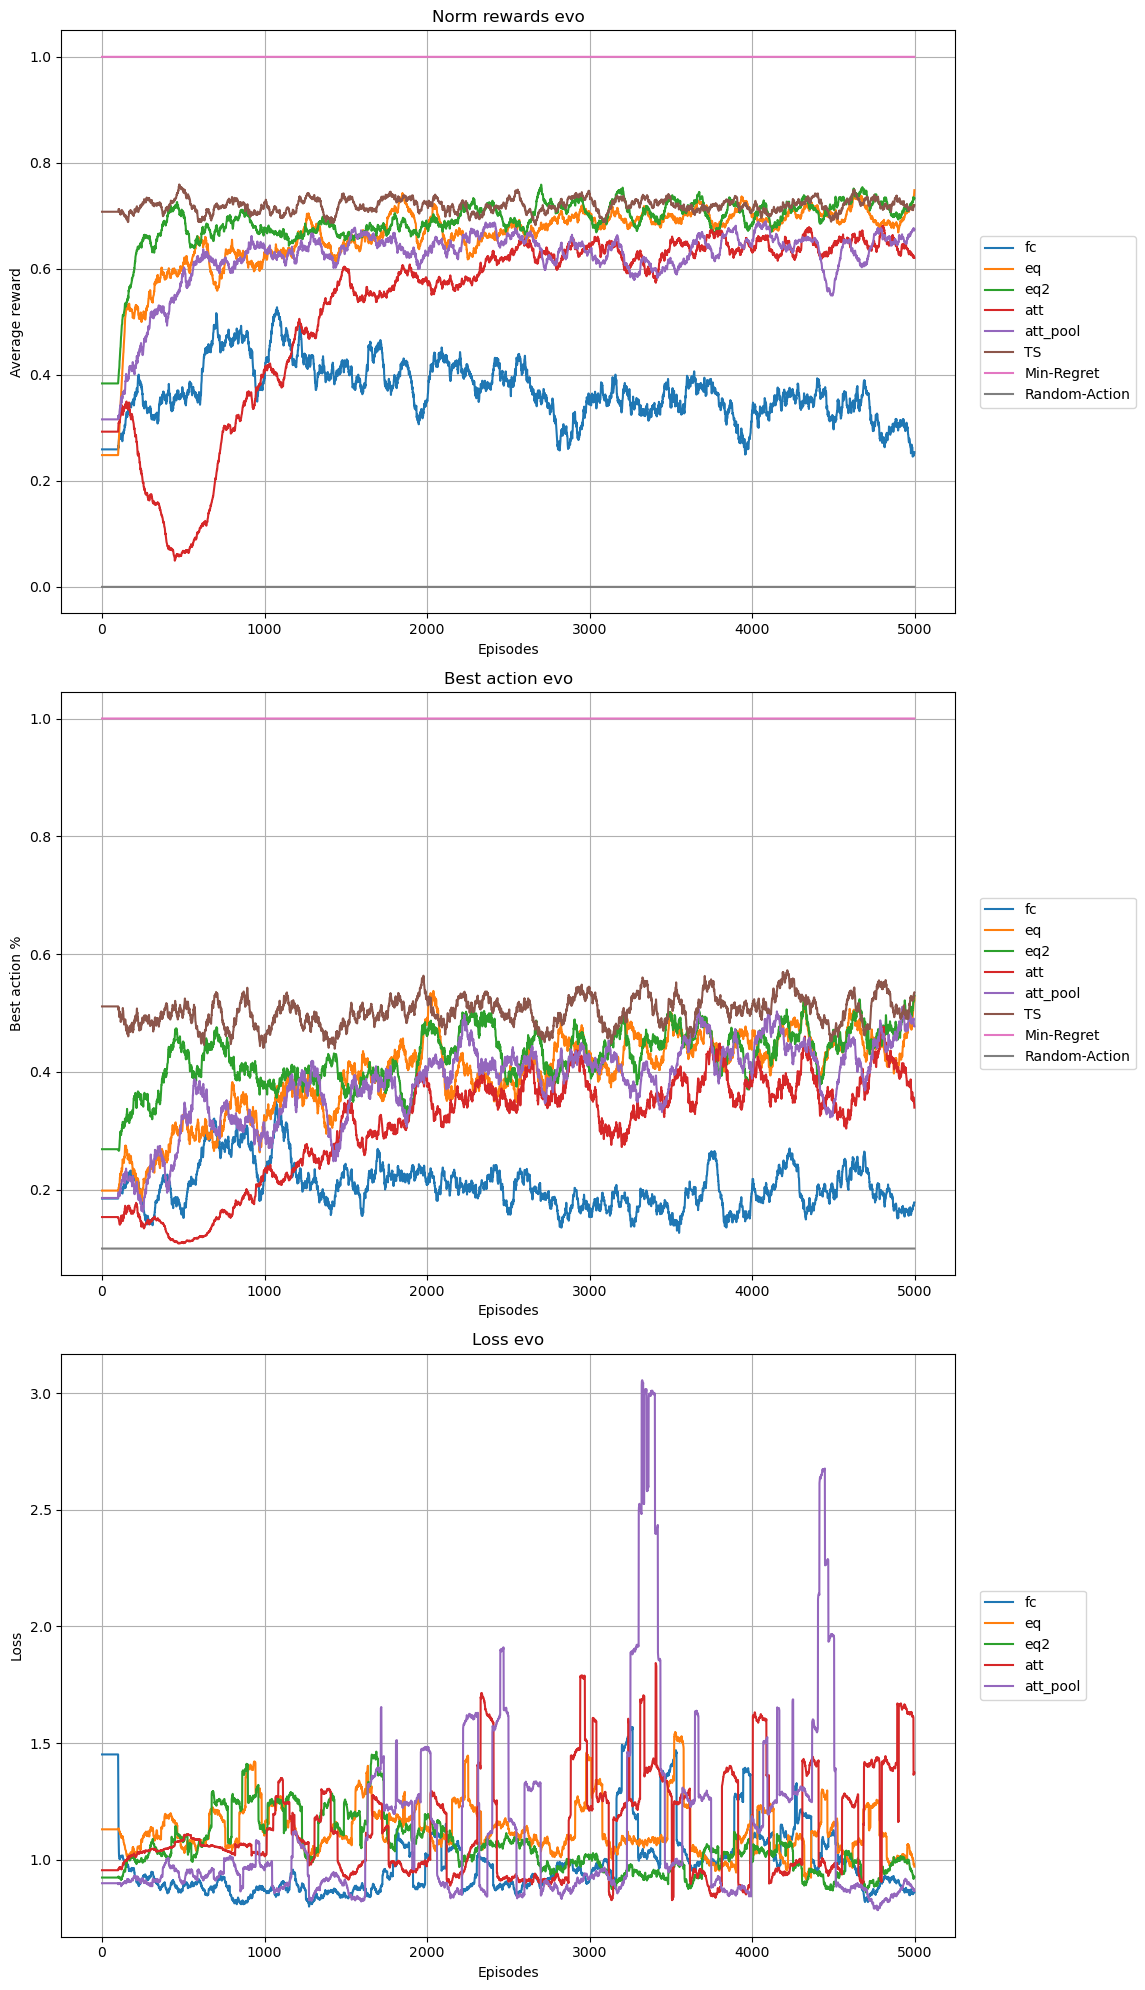

In [33]:
# Custom moving average function using numpy
def moving_average(data, window=10):
    data = np.asarray(data)
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window:] - cumsum[:-window]) / float(window)

# Pad the result to match original length
def smooth(data, window):
    smoothed = moving_average(data, window)
    # Prepend with first value to maintain length
    pad = [smoothed[0]] * (len(data) - len(smoothed))
    return np.concatenate([pad, smoothed])

# Example usage
fig, axs = plt.subplots(3, 1, figsize=(12, 20))

rolling_window = 100

for i, evo in enumerate(list(metrics.keys())[:3]):
    print(evo)
    ax = axs[i]
    for name, evolution in metrics[evo].items():
        smoothed = smooth(evolution, rolling_window)
        ax.plot(range(len(smoothed)), smoothed, label=name)

    ax.set_title(evo.replace('_', ' ').capitalize())
    ax.set_xlabel('Episodes')
    ax.set_ylabel(['Average reward', 'Best action %', 'Loss'][i])
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()


# Evaluation

In [34]:
# Constants
n_machines = 10
rwin = 1.0
rloss = 0.0
batch_size = 1

# # Device setup
# device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
# print('Using device:', device)

# dqn_models = {
#     'fc': DQN_FC(n_machines),
#     'eq': DQN_Equivariant(n_machines),
#     'eq2': DQN_PESymetry(n_machines),
#     'att': DQN_AttPE(n_machines),
#     'att_pool': DQN_AttPE_Pool(n_machines),
# }

# for name, model in dqn_models.items():
#     model.load_state_dict(torch.load(f"models/dqn_{name}.pth", map_location=device))
#     model.to(device)

In [40]:
class Validation():
    def __init__(self, models, nb_episodes, n_machines, rwin, rloss):
        self.models = models
        self.nb_episodes = nb_episodes
        self.n_machines = n_machines
        self.rwin, self.rloss = rwin, rloss

    def run(self):
        norm_rewards_evo = defaultdict(list)
        best_action_evo = defaultdict(list)
        for name, model in self.models.items():
            model.eval()

        all_names = list(self.models.keys()) + ['TS', 'Min-Regret', 'Random-Action']
        
        for max_round in np.arange(50,501,10):
            print(f"Max rounds: {max_round}")
            # For each max_round, run nb_episodes and mean the results
            ##############
            norm_rewards = {name: 0.0 for name in all_names}
            best_action_counts = {name: 0 for name in all_names}
            for episode in range(self.nb_episodes):
                total_rewards = {name: 0.0 for name in all_names}
                seed = np.random.randint(0, 10000)

                for name, model in self.models.items():
                    # Set same seed for each environment (reproducibility)
                    env = Slots(n_machines=self.n_machines, rwin=self.rwin, rloss=self.rloss, max_rounds=max_round, seed=seed)
                    best_arm = np.argmax(env.probs.copy())
                    state = env.reset()
                    done = False

                    # Run until done
                    while not done:
                        action = select_action(model, state, epsilon=0.0)
                        if action == best_arm:
                            best_action_counts[name] += 1
                        state, reward, done, _ = env.step(action)
                        total_rewards[name] += reward

                # ---- Thompson Sampling ----
                env = Slots(self.n_machines, rwin, rloss, max_round, seed)
                best_arm = np.argmax(env.probs)
                state = env.reset(); done=False
                alpha, beta = np.ones(self.n_machines), np.ones(self.n_machines)
                while not done:
                    a = np.argmax(np.random.beta(alpha, beta))
                    if a == best_arm:
                        best_action_counts['TS'] += 1
                    _, r, done, _ = env.step(a)
                    total_rewards['TS'] += r
                    if r>0: alpha[a]+=1
                    else:   beta[a] +=1

                # ---- Min-Regret and RandomAction ----
                total_rewards['Min-Regret'] = (rwin*max(env.probs) - rloss*(1-max(env.probs)))*max_round
                total_rewards['Random-Action'] = (rwin*np.mean(env.probs) - rloss*(1-np.mean(env.probs)))*max_round

                # Cumulative normalized rewards
                for name in all_names:
                    norm_rewards[name] += (total_rewards[name]-total_rewards['Random-Action'])/(total_rewards['Min-Regret']-total_rewards['Random-Action'])
            
            #############
            best_action_counts['Min-Regret'] = self.nb_episodes*max_round
            best_action_counts['Random-Action'] = self.nb_episodes*max_round/n_machines
            
            for name in all_names:
                # Mean the normalized rewards
                normalized_reward = norm_rewards[name]/self.nb_episodes
                norm_rewards_evo[name].append(normalized_reward)
                best_action_evo[name].append(best_action_counts[name] / (max_round*self.nb_episodes))

        return norm_rewards_evo, best_action_evo

In [41]:
valid_rewards_evo, valid_action_evo = Validation(dqn_models, 100, n_machines, rwin, rloss).run()

Max rounds: 50
Max rounds: 60
Max rounds: 70
Max rounds: 80
Max rounds: 90
Max rounds: 100
Max rounds: 110
Max rounds: 120
Max rounds: 130
Max rounds: 140
Max rounds: 150
Max rounds: 160
Max rounds: 170
Max rounds: 180
Max rounds: 190
Max rounds: 200
Max rounds: 210
Max rounds: 220
Max rounds: 230
Max rounds: 240
Max rounds: 250
Max rounds: 260
Max rounds: 270
Max rounds: 280
Max rounds: 290
Max rounds: 300
Max rounds: 310
Max rounds: 320
Max rounds: 330
Max rounds: 340
Max rounds: 350
Max rounds: 360
Max rounds: 370
Max rounds: 380
Max rounds: 390
Max rounds: 400
Max rounds: 410
Max rounds: 420
Max rounds: 430
Max rounds: 440
Max rounds: 450
Max rounds: 460
Max rounds: 470
Max rounds: 480
Max rounds: 490
Max rounds: 500


In [42]:
import pickle

norm_rewards_evo
best_action_evo
loss_evo

valid_metrics = {
    'valid_rewards_evo': valid_rewards_evo,
    'valid_action_evo': valid_action_evo
}

with open('valid_metrics.pkl', 'wb') as f:
    pickle.dump(valid_metrics, f)

norm_rewards_evo
best_action_evo


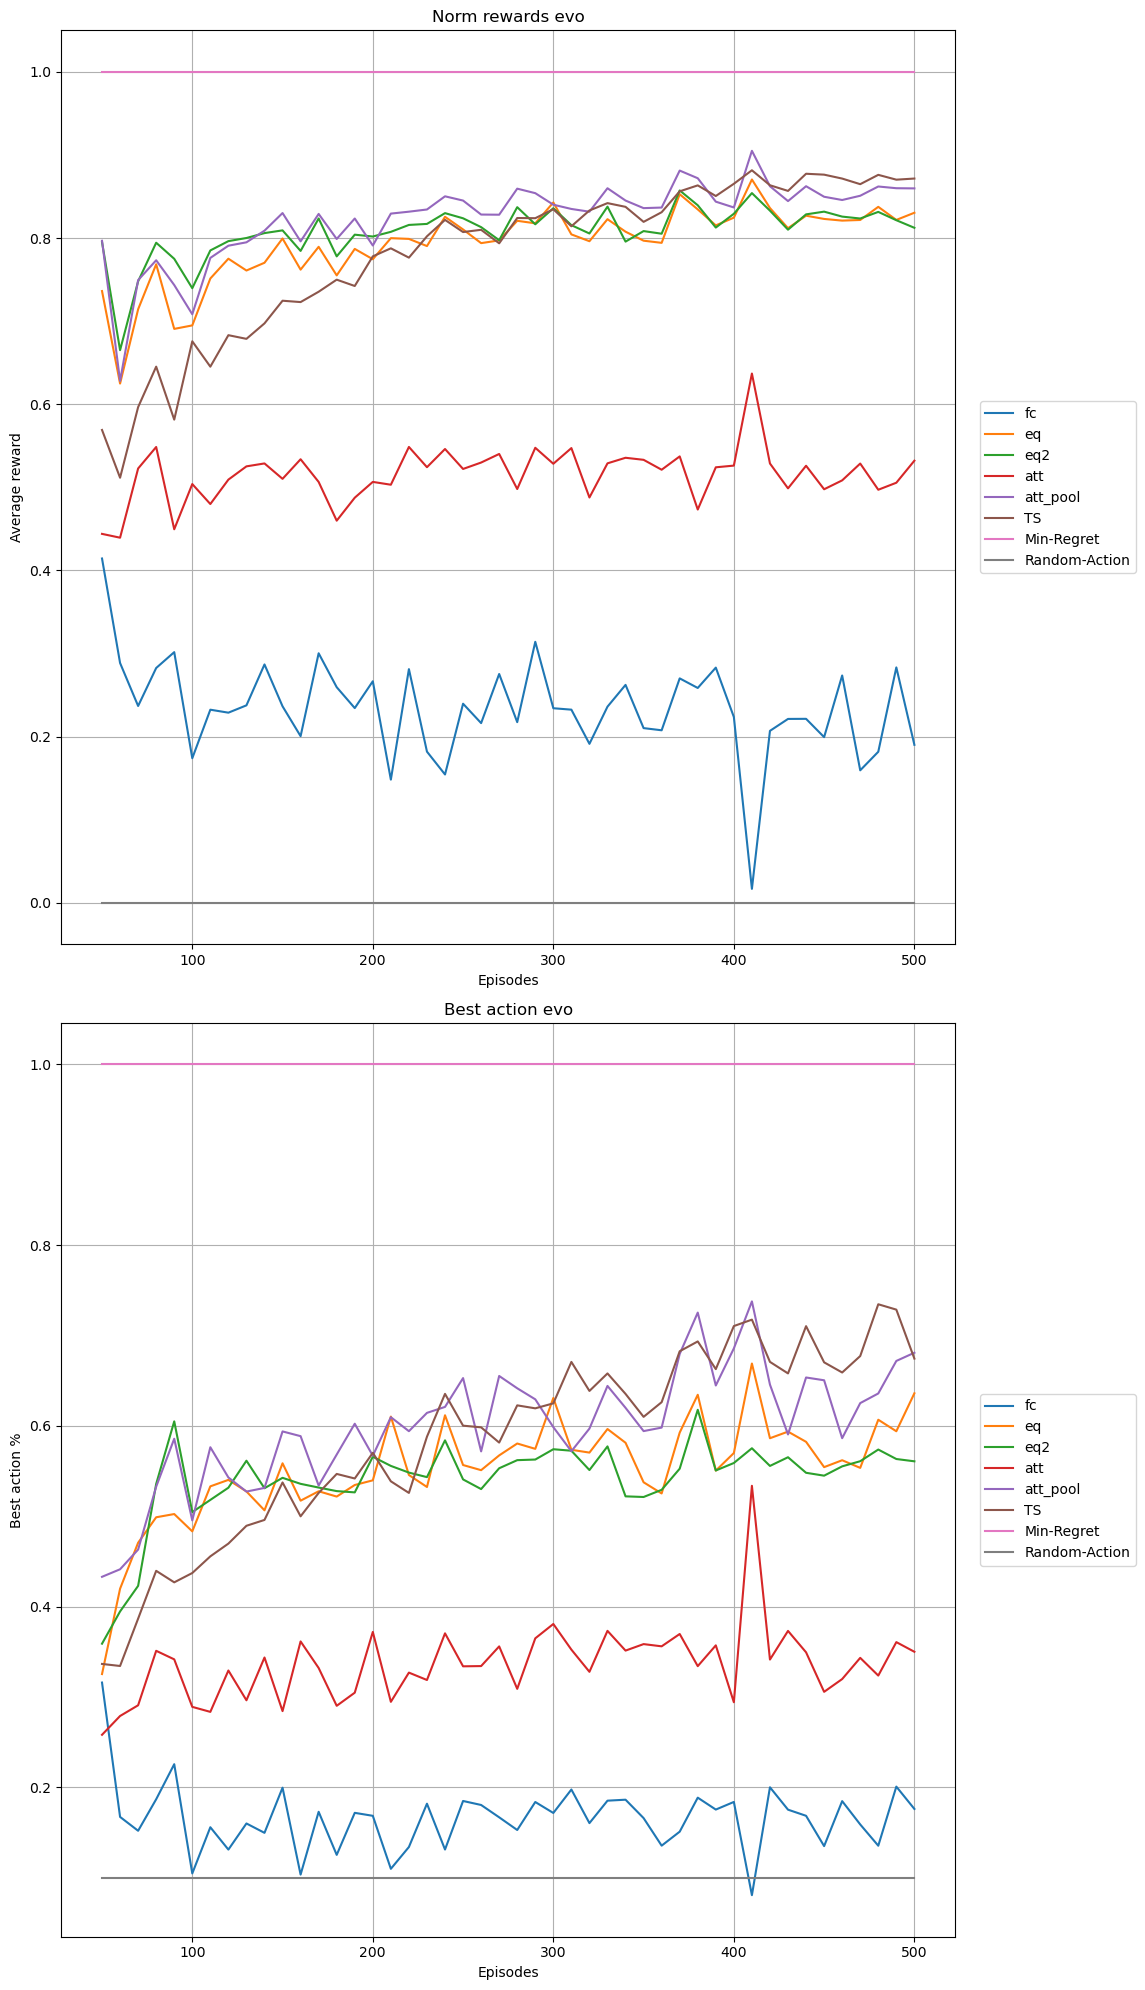

In [43]:
metrics_valid = {
    'norm_rewards_evo': valid_rewards_evo,
    'best_action_evo': valid_action_evo
}

fig, axs = plt.subplots(2, 1, figsize=(12, 20))

rolling_window = 1

for i, evo in enumerate(list(metrics_valid.keys())):
    print(evo)
    ax = axs[i]
    for name, evolution in metrics_valid[evo].items(): 
        smoothed = smooth(evolution, rolling_window)
        ax.plot(np.arange(50,501,10), smoothed, label=name)

    ax.set_title(evo.replace('_', ' ').capitalize())
    ax.set_xlabel('Episodes')
    ax.set_ylabel(['Average reward', 'Best action %'][i])
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()